In [291]:
# Imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import training data to pandas dataframe
df = pd.read_csv("train.csv")

# Splitting data 80% (df_80) for training and 20% (df_20) for testing 
total_points = 1460
per_80 = np.int_(0.8 * np.ceil(total_points))
per_20 = total_points - per_80

# Trimming Down
df_bm = df.loc[:,['Neighborhood','GrLivArea','YearBuilt','OverallQual','CentralAir', \
                  'SalePrice','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath', \
                  'TotalBsmtSF','BsmtUnfSF']]


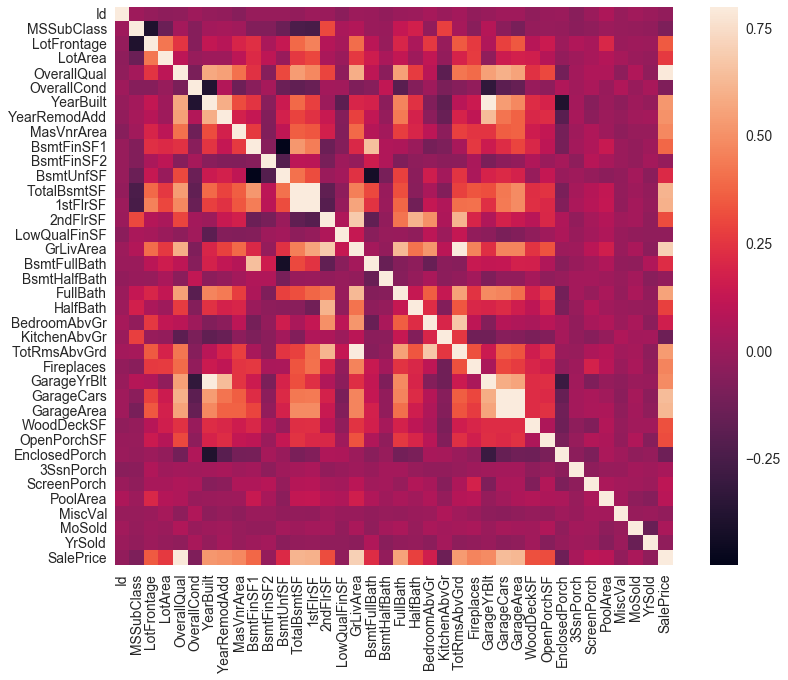

In [292]:
# correlation matrix (heat meap) for all categories
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

I want to try to create a model using the best of the features. I decided to use the top 10 features and to see how good of an accuracy it would produce. I created a new heat map of the top 10 to try to see the relationship of the top 10 features. 

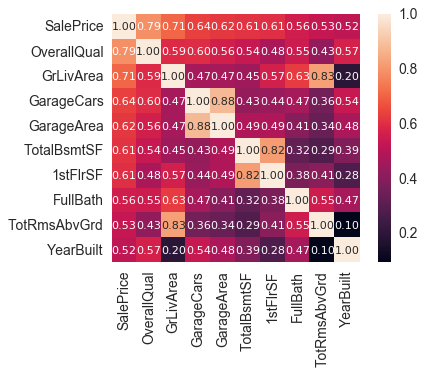

In [293]:
# Grabbing Top 10 from the correlation matrix and seeing their correlation with each other
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# Pearson product-moment correlation 
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

I did find a strong correlation between TotalBsmtSF and 1stFlrSF as well as GrLivArea and TotRmsAbvGrd and even GarageCars and GarageArea. Which is weird but hey lets go with it. So we are able to combine these features as well. Based on the heatmap I will choose to keep the parameters that are more strongly correlated with SalesPrice. So GarageCars, GrLivArea, and (even though they are the same) TotalBsmtSF. 

In [294]:
df_train = df.loc[:,['Id', 'OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath', \
                     'YearBuilt' , 'SalePrice']]
# Showing top 5 houses 
df_train[:5]

,Id,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,SalePrice
0,1,7,1710,2,856,2,2003,208500
1,2,6,1262,2,1262,2,1976,181500
2,3,7,1786,2,920,2,2001,223500
3,4,7,1717,3,756,1,1915,140000
4,5,8,2198,3,1145,2,2000,250000


# Data Preprocessing


In [295]:
# Overall Quality. The values are already 1 thru 10 so I will make missing data 0
df_train['OverallQual'].fillna('0') 
# Same with Garage Cars and Full bath
df_train['GarageCars'].fillna('0')
df_train['FullBath'].fillna('0')

df_train[:5]

,Id,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,SalePrice
0,1,7,1710,2,856,2,2003,208500
1,2,6,1262,2,1262,2,1976,181500
2,3,7,1786,2,920,2,2001,223500
3,4,7,1717,3,756,1,1915,140000
4,5,8,2198,3,1145,2,2000,250000


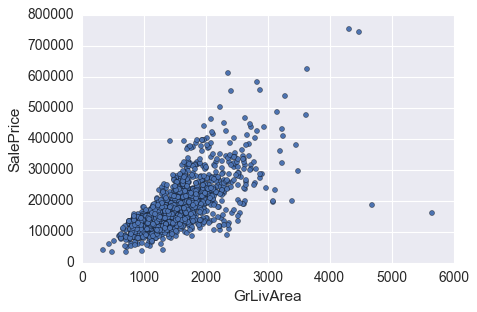

In [296]:
# Ground Living Area. 
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

I've noticed that there was two outliers showing a lot of Ground living area but low prices. I base this on maybe it being a farm. I feel comforatble taking them out so it doesn't mess up my model. I got the points places by a tutorial I was following

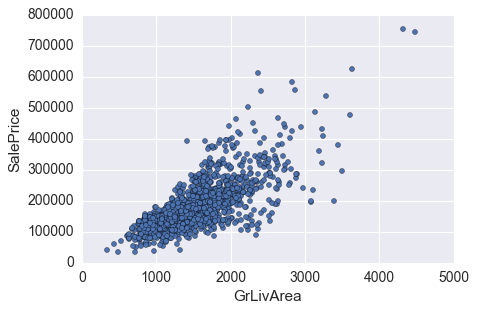

In [297]:
#deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

# That looks better 
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

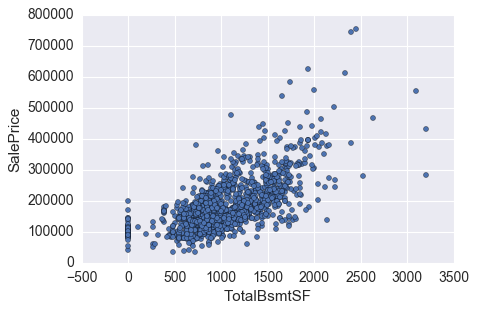

In [298]:
# Total Basement Square footage.
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# Based on the plot I don't believe there is no outliers so I will leave it alone. 

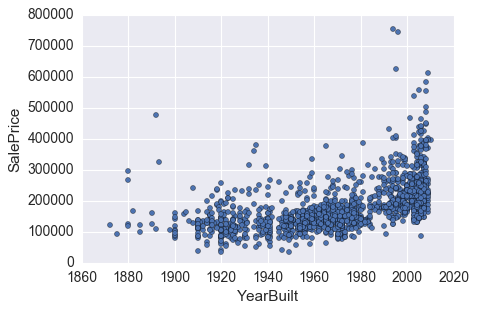

In [299]:
# Year Built
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# Again no significant outliers so I will leave this alone as well. 

# Basic Linear Regression

# Get input data


In [300]:
# Gettting 80% of the data for training and setting X to be the parameters and Y be the saleprice
df_train_80 = df_train[:per_80]
df_X = df_train_80.loc[:,['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath', \
                     'YearBuilt']]
df_y = df_train_80.loc[:, ['SalePrice']]

# Data Preprocessing

In [301]:
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# df_X[['GrLivArea', 'TotalBsmtSF', 'YearBuilt']] \
  # = scaler.fit_transform(df_X[['GrLivArea', 'TotalBsmtSF', 'YearBuilt']])
    
# var = 'TotSF'
# data = pd.concat([df_y['SalePrice'], df_X[var]], axis=1)
# data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# view the first 5 houses transformed set
df_X[:5]

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
0,7,1710,2,856,2,2003
1,6,1262,2,1262,2,1976
2,7,1786,2,920,2,2001
3,7,1717,3,756,1,1915
4,8,2198,3,1145,2,2000


In [302]:
import torch
from torch.autograd import Variable

In [303]:
# Switching Data Frames into Variables to be able to run Linear Regression
X = Variable(torch.Tensor(df_X.values.tolist()))
y = Variable(torch.Tensor(df_y.values.tolist()))

# Linear Regression

In [304]:
total_houses = per_80 
total_parameters = 6
W = Variable(torch.ones(total_parameters, 1), requires_grad=True)
b = Variable(torch.ones(1), requires_grad=True)

In [305]:
import torch.nn as nn

learning_rate = 1e-2
optimizer = torch.optim.Adam([W, b], lr=learning_rate)
loss_fxn = nn.MSELoss()
losses = []
total_loss = 0
t = 0

# I switched it temp to iterations to see what is going on 
stillTraining = 100000
while (stillTraining > 0):
    predictions = X.mm(W) + b
    loss = loss_fxn(predictions, y)
    losses.append(loss.data[0])
    
    if t % 10000 == 0:
        print loss.data[0]
    if (loss.data[0] < 1):
        print loss.data[0]
        stillTraining = False
    t = t + 1
    stillTraining = stillTraining - 1
    
    optimizer.zero_grad()   
    loss.backward()
    optimizer.step()

37117456384.0
2439647744.0
1907597184.0
1900131456.0
1892714880.0
1885344640.0
1878014080.0
1870718592.0
1863468416.0
1856263808.0


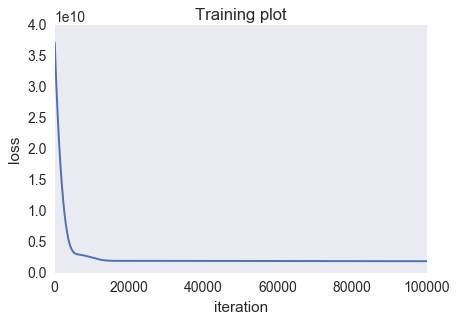

In [306]:
# Plotting results from training
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Training plot')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

Based on my training plot I have seen that it does converge but to a high error. Need to possibly reformat my parameters?

# Testing

In [ ]:
# df_bm_20 = df_bm[:per_20]
# test_total_houses = per_20
#test_df_X = df_bm_20.loc[:,['YearBuilt', 'TotSF', 'TotBathroom']]
#test_df_y = df_bm_20.loc[:, ['SalePrice']]
#test_X = Variable(torch.Tensor(test_df_X.values.tolist()))
#test_y = Variable(torch.Tensor(test_df_y.values.tolist()))

#test_predictions = test_X.mm(W) + b
#test_loss = loss_fxn(test_predictions, test_y)
#print(test_loss.data[0])